# 4. Train model. XGBoost

In [5]:
%config IPCompleter.use_jedi = True
%config IPCompleter.greedy = True

import pandas as pd
import numpy as np
from pathlib import Path
import os

%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from fraudlib.utils import (
    load_features,
    pr_at_thresholds,
    cm_for_threshold,
    explain_confusion_matrix,
    save_model_thresholds,
)

In [6]:
upstream = {
    'feature_engineering': {
        'train': 'data/interim/x_train_features_v2.parquet.gzip',
        'val': 'data/interim/x_val_features_v2.parquet.gzip',
        'test': 'data/interim/x_test_features_v2.parquet.gzip'
    }
}
product = None
ROOT = Path(os.path.abspath("")).resolve().parents[0]
DATA = os.path.join(ROOT, "data")
INTERIM_DATA = os.path.join(DATA, "interim")
VERSION="v2"

## Load data

In [9]:
import sys, jedi, IPython
print("Python:", sys.version)
print("IPython:", IPython.__version__)
print("Jedi:", jedi.__version__)
pd.Dat

Python: 3.12.12 (main, Oct 21 2025, 02:17:12) [GCC 14.2.0]
IPython: 9.6.0
Jedi: 0.19.2


In [5]:
X_train = pd.read_parquet(
    os.path.join(INTERIM_DATA, f"x_train_features_{VERSION}.parquet.gzip")
)
X_val = pd.read_parquet(
    os.path.join(INTERIM_DATA, f"x_val_features_{VERSION}.parquet.gzip")
)
X_test = pd.read_parquet(
    os.path.join(INTERIM_DATA, f"x_test_features_{VERSION}.parquet.gzip")
)

y_train = X_train["tx_fraud"]
y_val = X_val["tx_fraud"]
y_test = X_test["tx_fraud"]

FEATURES = load_features(
    os.path.join(INTERIM_DATA, f"features_{VERSION}.yaml")
)
FEATURES

['tx_amount',
 'sector_id',
 'tx_amount_log',
 'hour',
 'month',
 'is_month_start',
 'is_month_end',
 'is_weekend',
 'tx_amount_log_mean',
 'tx_amount_log_std',
 'tx_amount_log_deviates',
 'secs_since_prev_tx',
 'burst_id',
 'n_tx_in_burst',
 'burst_mean',
 'burst_std',
 'n_trx_per_burst_deviates',
 'hour_zscore',
 'hour_zscore_deviates',
 'rolling_median',
 'q1',
 'q3',
 'iqr',
 'amount_robust_rolling20',
 'is_amount_robust_rolling_outlier',
 'day_of_week_mean',
 'day_of_week_std',
 'is_day_of_week_mean_outlier',
 'day_of_week_zscore',
 'is_day_of_week_zscore_outlier',
 'n_tx_in_prev_24h',
 'q90_prev',
 'is_24h_burst',
 'is_24h_burst_fixed',
 'day_of_week',
 'z_in_day_robust',
 'is_anomalous_in_day',
 'fraud_burst_candidate']

## Train model

In [4]:
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
params = {
    "eval_metric": "aucpr",
    "scale_pos_weight": scale_pos_weight,
    "random_state": 42,
    "n_jobs": -1,
    "tree_method": "hist",
    "gpu_id": 0,
    "predictor": "cpu_predictor",
}
xgb = XGBClassifier(**params)

xgb.fit(X_train[FEATURES], y_train, eval_set=[(X_val[FEATURES], y_val)], verbose=50)
y_pred_proba = xgb.predict_proba(X_val[FEATURES])[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC:  {pr_auc:.3f}")

[0]	validation_0-aucpr:0.18286


/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:15:09] WARNING: /Users/runner/work/xgboost/xgboost/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:15:09] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:15:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[50]	validation_0-aucpr:0.49057
[99]	validation_0-aucpr:0.47308
ROC AUC: 0.976
PR AUC:  0.473


## Visualization

### Precision-recall curve

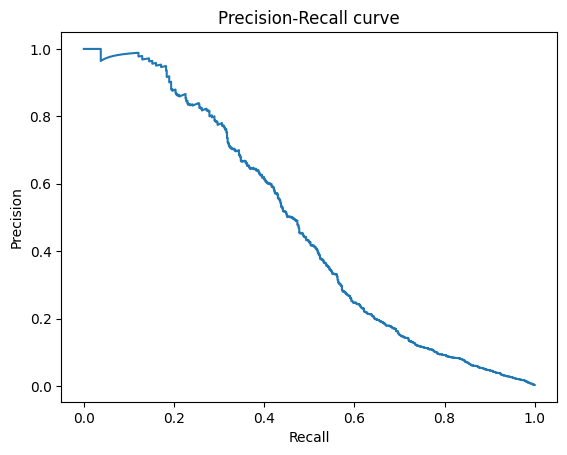

In [5]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.show()

## Thresholds grid

In [6]:
grid = np.sort(np.unique(np.round(y_pred_proba, 3)))
rows = []

for t in sorted(set(grid)):
    y_hat = (y_pred_proba >= t).astype(int)

    pr = precision_score(y_val, y_hat, zero_division=0)
    rc = recall_score(y_val, y_hat, zero_division=0)
    f1 = f1_score(y_val, y_hat, zero_division=0)
    f05 = fbeta_score(y_val, y_hat, beta=0.5, zero_division=0)
    f2 = fbeta_score(y_val, y_hat, beta=2, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_val, y_hat).ravel()

    rows.append((t, pr, rc, f1, f05, f2, tp, fp, fn, tn))

grid_df = pd.DataFrame(
    rows,
    columns=["thr", "precision", "recall", "f1", "f0.5", "f2", "TP", "FP", "FN", "TN"],
).sort_values("thr")

In [7]:
grid_df.head(30)

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
0,0.000,0.003098,1.000000,0.006176,0.003869,0.015298,718,231078,0,0
1,0.001,0.017593,0.970752,0.034560,0.021892,0.082019,697,38921,21,192157
2,0.002,0.023069,0.954039,0.045048,0.028663,0.105171,685,29009,33,202069
3,0.003,0.027223,0.945682,0.052923,0.033786,0.122061,679,24263,39,206815
4,0.004,0.030497,0.934540,0.059067,0.037813,0.134880,671,21331,47,209747
5,0.005,0.033385,0.927577,0.064451,0.041359,0.145918,666,19283,52,211795
6,0.006,0.036071,0.924791,0.069434,0.044654,0.156015,664,17744,54,213334
7,0.007,0.038426,0.920613,0.073772,0.047536,0.164641,661,16541,57,214537
8,0.008,0.040557,0.912256,0.077662,0.050139,0.172169,655,15495,63,215583
9,0.009,0.042676,0.908078,0.081520,0.052725,0.179614,652,14626,66,216452


In [ ]:
max_f1 = grid_df[grid_df["f1"] == grid_df["f1"].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
862,0.904,0.586074,0.422006,0.490688,0.54379,0.447035,303,214,415,230864


In [ ]:
max_f05 = grid_df[grid_df["f0.5"] == grid_df["f0.5"].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
924,0.974,0.761745,0.316156,0.44685,0.594241,0.358044,227,71,491,231007


In [ ]:
max_f2 = grid_df[grid_df["f2"] == grid_df["f2"].max()]

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
566,0.574,0.33087,0.561281,0.416322,0.360465,0.492665,403,815,315,230263


## Precision-recall curve with marked thresholds

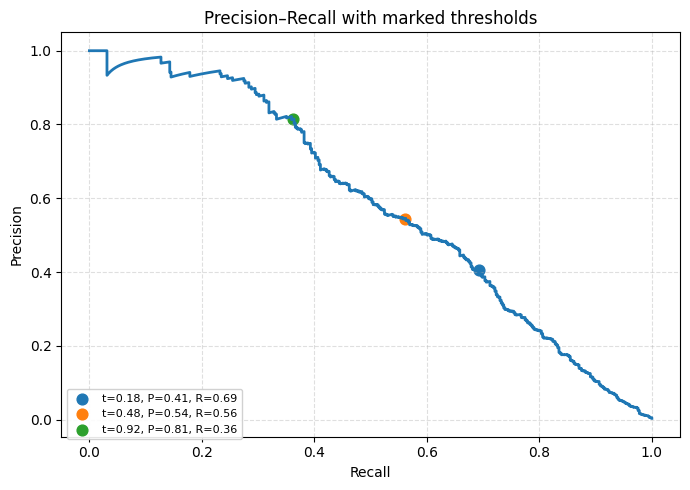

In [40]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(recall, precision, lw=2)

mark_thrs = [max_f2.thr.values[0], max_f1.thr.values[0], max_f05.thr.values[0]]

points = pr_at_thresholds(mark_thrs, thresholds, precision, recall)

handles = []
for t, p, r, i in points:
    plt.scatter(r, p, s=60, label=f"t={t:.2f}, P={p:.2f}, R={r:.2f}")
plt.legend(fontsize=8, loc="lower left")

ax.legend(
    fontsize=8, loc="lower left", bbox_to_anchor=(0, -0.02), ncol=1, framealpha=0.9
)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall with marked thresholds")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

## Confusion matrixes for thresholds

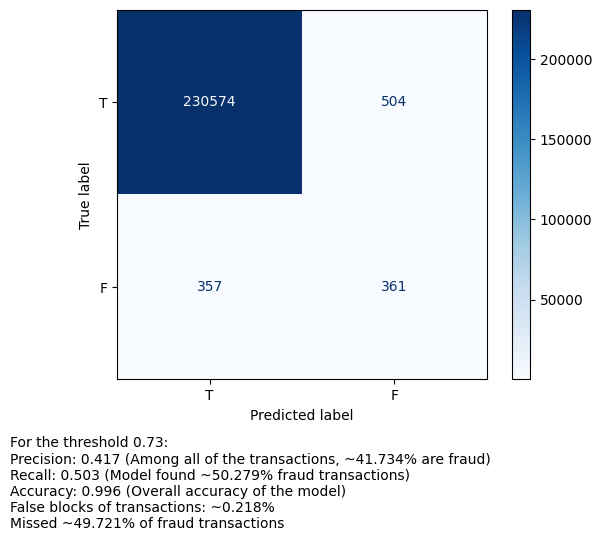

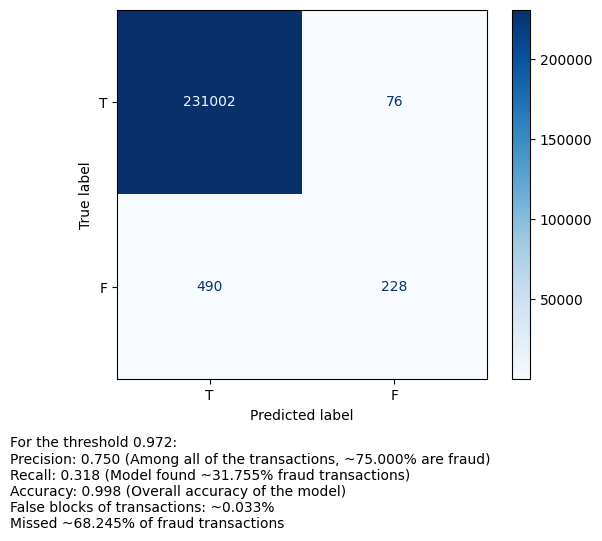

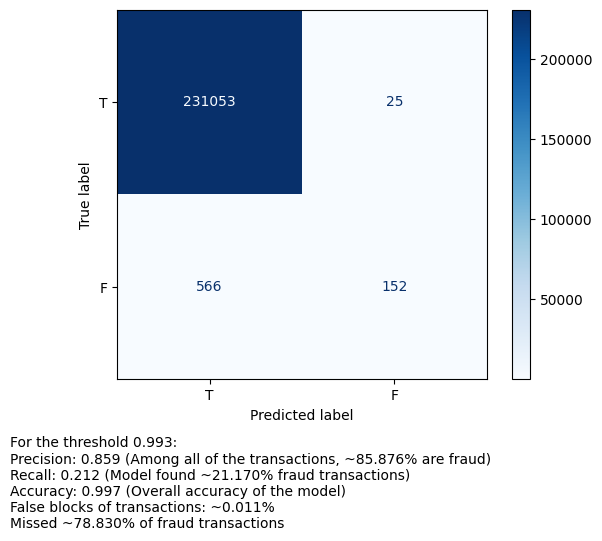

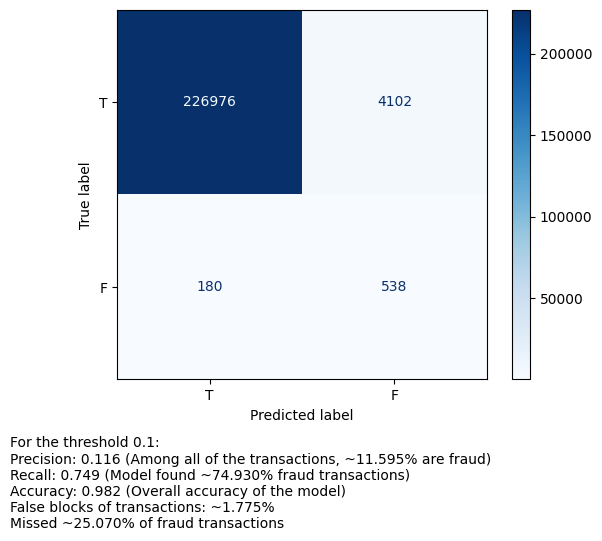

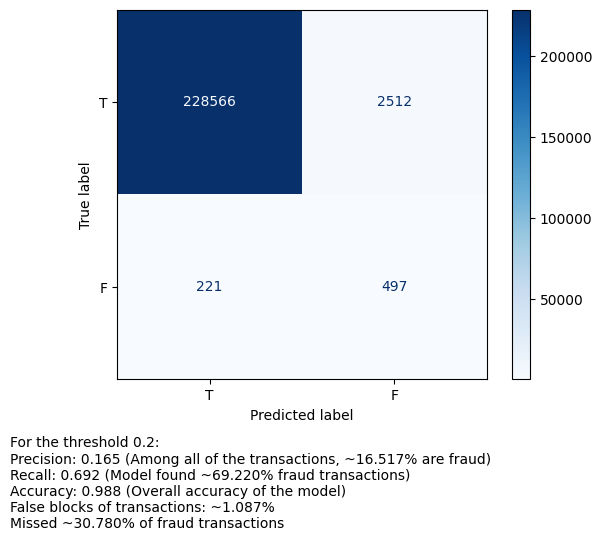

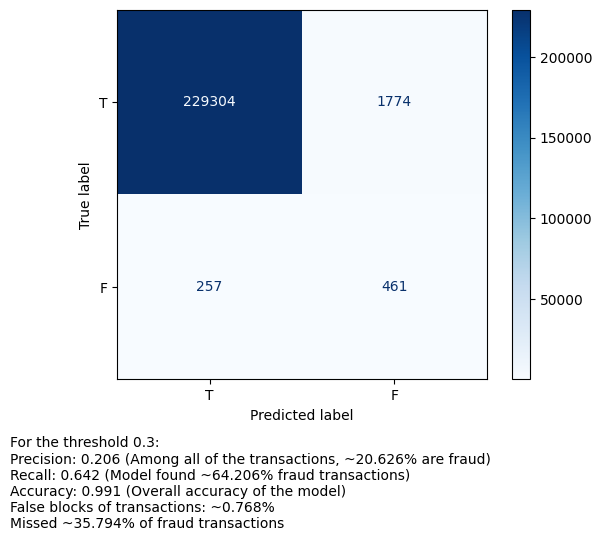

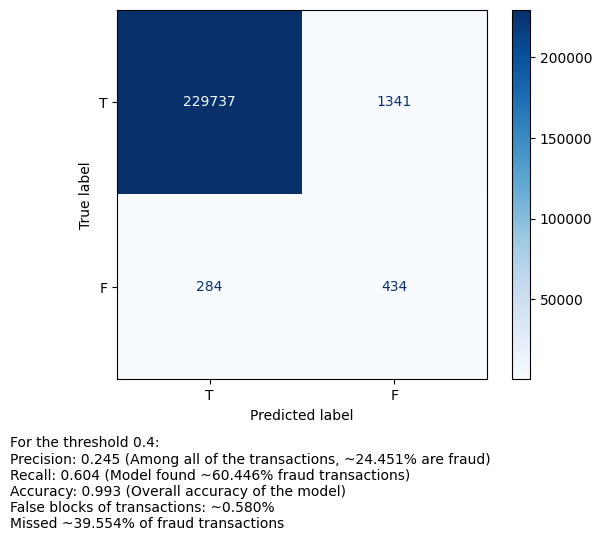

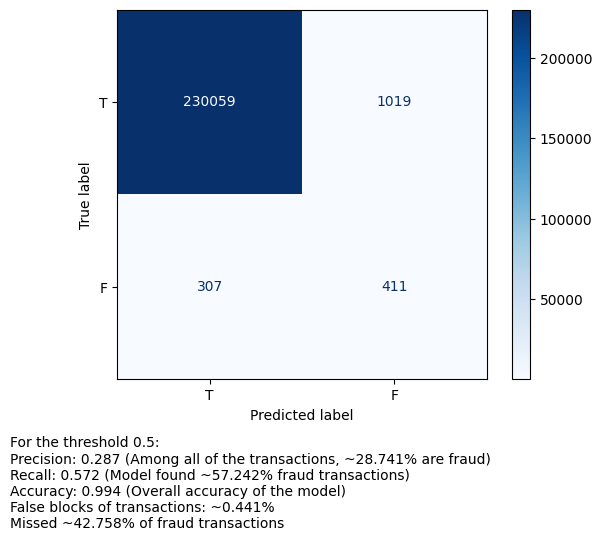

In [12]:
for thr in mark_thrs + [0.1, 0.2, 0.3, 0.4, 0.5]:
    conf_matrix = cm_for_threshold(thr, y_pred_proba, y_val)
    metrics = explain_confusion_matrix(conf_matrix, thr)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=["T", "F"]
    )
    disp.plot(cmap="Blues")
    disp.figure_.text(0, -0.2, "\n".join(metrics))

### Observations

* The less threshold is, the less number of missed transactions

## Tune model

* For tuning, use [optuna](https://github.com/optuna/optuna) library

In [13]:
import optuna


def objective(trial):
    test_params = {
        **params,
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 10000, 100),
        "eta": trial.suggest_discrete_uniform("eta", 0.01, 0.1, 0.01),
        "reg_alpha": trial.suggest_int("reg_alpha", 1, 50),
        "reg_lambda": trial.suggest_int("reg_lambda", 5, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
    model = XGBClassifier(**test_params)
    model.fit(
        X_train[FEATURES], y_train, eval_set=[(X_val[FEATURES], y_val)], verbose=False
    )
    pred_proba = model.predict_proba(X_val[FEATURES])[:, 1]
    score = average_precision_score(y_val, pred_proba)
    return score

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

[I 2025-10-19 16:16:07,495] A new study created in memory with name: no-name-d062b9ab-55c3-4811-9989-e86216b269eb
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_69373/3995495039.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_69373/3995495039.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.

In [15]:
study.best_trial.params

{'max_depth': 13,
 'subsample': 0.65,
 'n_estimators': 5100,
 'eta': 0.03,
 'reg_alpha': 6,
 'reg_lambda': 41,
 'min_child_weight': 8,
 'colsample_bytree': 0.9426198255397087}

In [16]:
optuna.visualization.plot_param_importances(study)

## Train with parameters

* Based on previous step, we are going to train model with best attributes and verify it on test scope

In [17]:
best_params = {**params, **study.best_trial.params}
model = XGBClassifier(**best_params)
model.fit(
    X_train[FEATURES], y_train, eval_set=[(X_val[FEATURES], y_val)], verbose=False
)
y_xgb_predict_proba = model.predict_proba(X_test[FEATURES])[:, 1]
roc_auc = roc_auc_score(y_test, y_xgb_predict_proba)
pr_auc = average_precision_score(y_test, y_xgb_predict_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC:  {pr_auc:.3f}")

/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[16:31:32] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.

/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[16:31:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "predictor" } are not used.




ROC AUC: 0.986
PR AUC:  0.584


### Visualization

#### Precision-recall curve

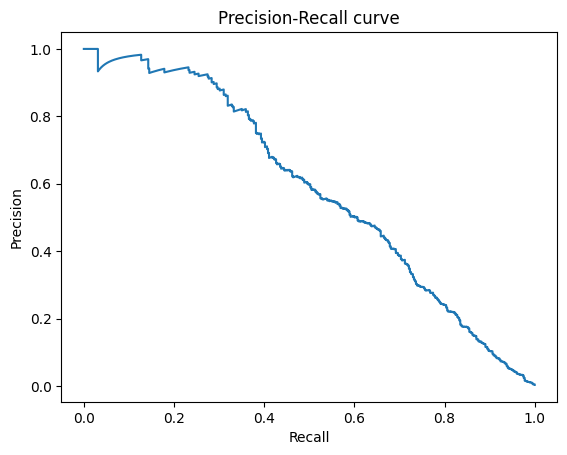

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, y_xgb_predict_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.show()

#### Thresholds grid

In [19]:
grid = np.sort(np.unique(np.round(y_xgb_predict_proba, 3)))
rows = []

for t in sorted(set(grid)):
    y_hat = (y_xgb_predict_proba >= t).astype(int)

    pr = precision_score(y_test, y_hat, zero_division=0)
    rc = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    f05 = fbeta_score(y_test, y_hat, beta=0.5, zero_division=0)
    f2 = fbeta_score(y_test, y_hat, beta=2, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    fp_rate = fp / (fp + tn)

    rows.append((t, pr, rc, f1, f05, f2, tp, fp, fn, tn, fp_rate))

grid_df = pd.DataFrame(
    rows,
    columns=[
        "thr",
        "precision",
        "recall",
        "f1",
        "f0.5",
        "f2",
        "TP",
        "FP",
        "FN",
        "TN",
        "fp_rate",
    ],
).sort_values("thr")

In [30]:
max_f1 = grid_df[grid_df["f1"] == grid_df["f1"].max()]

In [31]:
max_f05 = grid_df[grid_df["f0.5"] == grid_df["f0.5"].max()]

In [32]:
max_f2 = grid_df[grid_df["f2"] == grid_df["f2"].max()]

In [33]:
grid_df[(grid_df["recall"] > 0.6) & (grid_df["fp_rate"] < 0.05)].sort_values(
    by="f1", ascending=False
)

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN,fp_rate
273,0.328,0.483816,0.633929,0.548792,0.507868,0.596889,284,303,164,138096,0.002189
302,0.381,0.500000,0.607143,0.548387,0.518293,0.582192,272,272,176,138127,0.001965
272,0.326,0.482993,0.633929,0.548263,0.507143,0.596639,284,304,164,138095,0.002197
305,0.386,0.500924,0.604911,0.548028,0.518760,0.580797,271,270,177,138129,0.001951
260,0.310,0.476112,0.645089,0.547867,0.502434,0.602334,289,318,159,138081,0.002298
...,...,...,...,...,...,...,...,...,...,...,...
6,0.006,0.104512,0.899554,0.187268,0.126953,0.356763,403,3453,45,134946,0.024950
5,0.005,0.095294,0.908482,0.172494,0.116073,0.335642,407,3864,41,134535,0.027919
4,0.004,0.084956,0.915179,0.155480,0.103787,0.309761,410,4416,38,133983,0.031908
3,0.003,0.073106,0.924107,0.135493,0.089610,0.277666,414,5249,34,133150,0.037927


In [38]:
max_f2.thr.values[0]

np.float32(0.182)

#### Precision-recall curve with thresholds

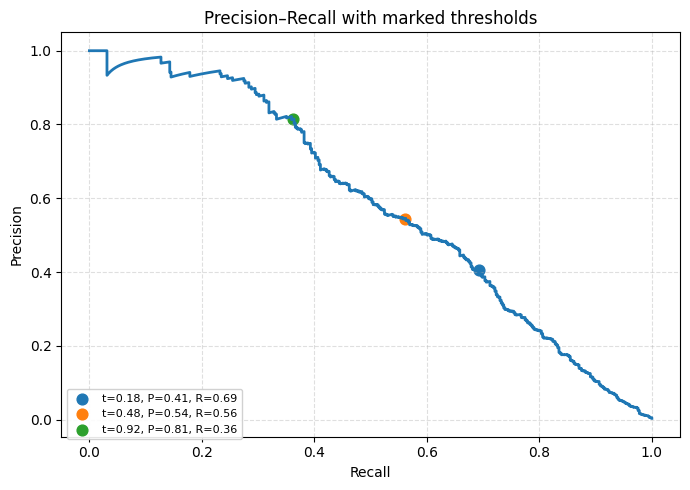

In [39]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(recall, precision, lw=2)

mark_thrs = [max_f2.thr.values[0], max_f1.thr.values[0], max_f05.thr.values[0]]

points = pr_at_thresholds(mark_thrs, thresholds, precision, recall)

handles = []
for t, p, r, i in points:
    plt.scatter(r, p, s=60, label=f"t={t:.2f}, P={p:.2f}, R={r:.2f}")
plt.legend(fontsize=8, loc="lower left")

ax.legend(
    fontsize=8, loc="lower left", bbox_to_anchor=(0, -0.02), ncol=1, framealpha=0.9
)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall with marked thresholds")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

#### Confusion matrices for thresholds

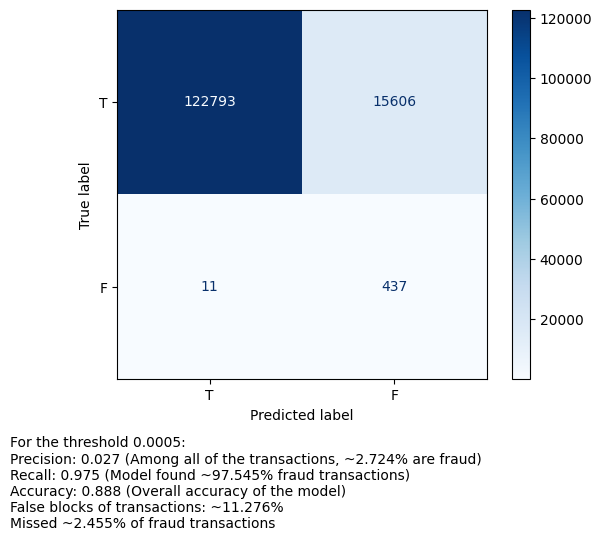

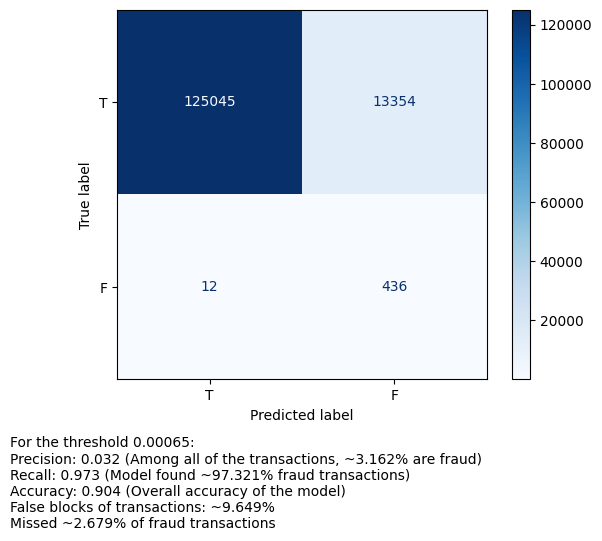

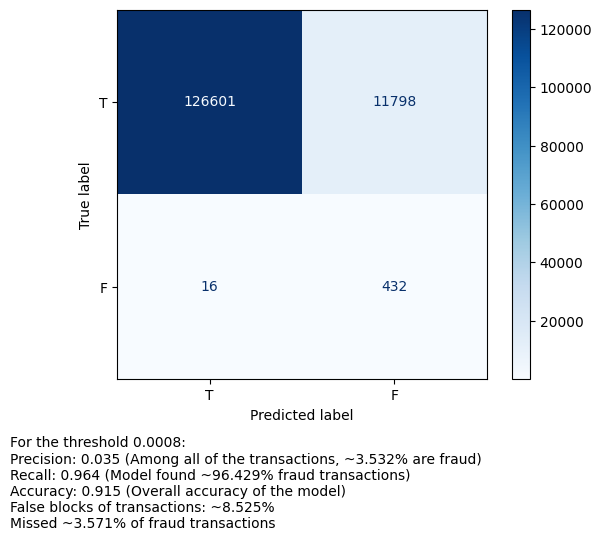

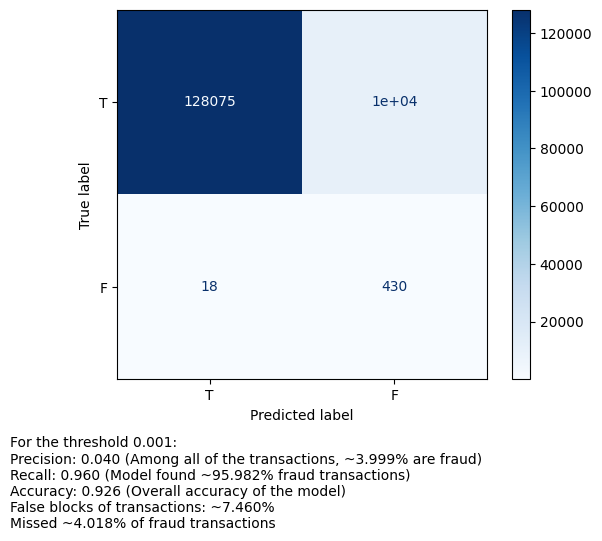

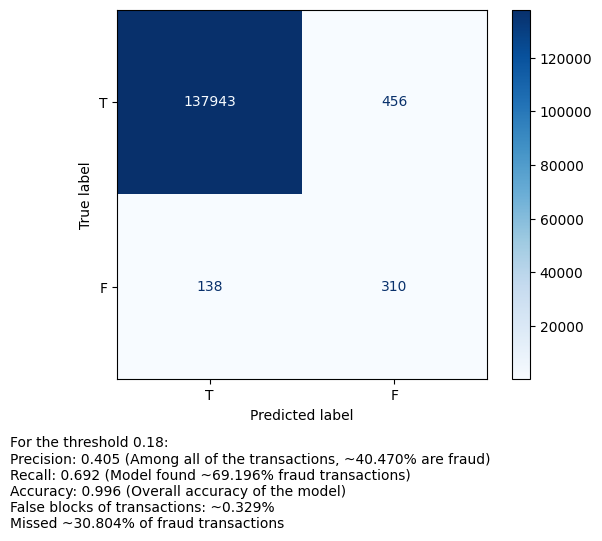

In [25]:
for thr in [0.0005, 0.00065, 0.0008, 0.001, 0.18]:
    conf_matrix = cm_for_threshold(thr, y_xgb_predict_proba, y_test)
    metrics = explain_confusion_matrix(conf_matrix, thr)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=["T", "F"]
    )
    disp.plot(cmap="Blues")
    disp.figure_.text(0, -0.2, "\n".join(metrics))

## Observations

* Best model result is achived with threshold = `0.001`

## Features importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

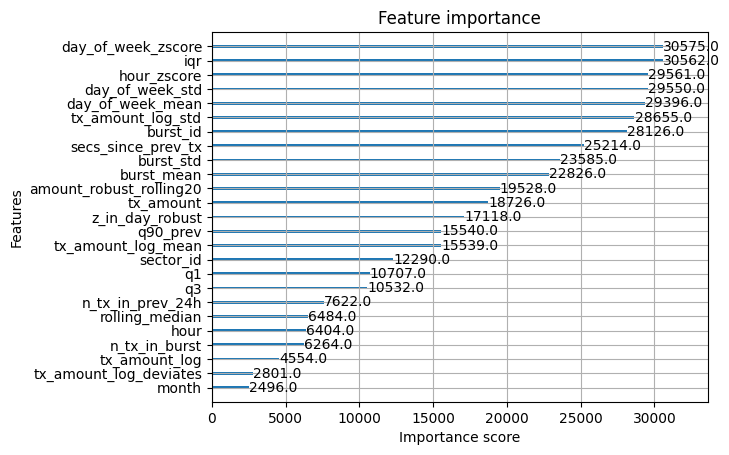

In [26]:
plot_importance(model, max_num_features=25)

## Save the model

In [ ]:
model.save_model(os.path.join(DATA, "models/xgboost.json"))

In [ ]:
loaded_model = XGBClassifier()
loaded_model.load_model(os.path.join(DATA, "models/xgboost.json"))

### Save thresholds

In [ ]:
save_model_thresholds(os.path.join(DATA, "models/thresholds.yaml"), {"xgboost": 0.001})